# 2. VAR Exercise

Olivier Blanchard (1989), “A Traditional Interpretation of Macroeconomic Fluctuations,” American Economic Review, vol. 79, no. 5, 1146-64.

논문의 순서를 따라, 주요 결과들 위주로 replicate 해 보았습니다.

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import sympy
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action = 'ignore')

In [2]:
df = pd.read_csv('blanchard.csv', parse_dates=['DATE'],index_col=['DATE'])

In [3]:
df[['dY','U','dP','dW','dM']] = df[['dY','U','dP','dW','dM']]/100

In [4]:
df

,dY,U,dP,dW,dM,t,S_2,S_3,S_4,D_1,D_2,D_3,D_4,D_5,D_6
DATE,,,,,,,,,,,,,,,
1965-04-01,0.012709,0.046667,0.005048,0.008957,0.005779,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1965-07-01,0.021268,0.043667,0.003712,0.008878,0.011459,2,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
1965-10-01,0.021972,0.041000,0.003017,0.010050,0.018146,3,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
1966-01-01,0.024114,0.038667,0.007756,0.008712,0.017233,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1966-04-01,0.003399,0.038333,0.008088,0.011091,0.010743,5,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985-10-01,0.008002,0.070333,0.006981,0.006443,0.028224,83,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
1986-01-01,0.008497,0.070333,0.007081,0.005651,0.021668,84,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1986-04-01,0.002942,0.071667,-0.001038,0.003001,0.038349,85,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## I. The Basic Approach

$Y$ : Logarithm of output

$U$ : Rate of unemployment

$P$ : Logarithm of the price level

$W$ : Logarithm of wage level

$M$ : Logarithm of nominal money

Five structual disturbances:
1. Autonomous shocks to aggregate demand
2. Shocks to labor supply and technology
3. Shocks to price
4. Shocks to wage setting
5. Shocks to nominal money

White-noise innovations to above 5 disturbances:
1. $e_d$ (aggregate demand)
2. $e_{\Theta}$ (labor supply and technology)
3. $e_p$ (price level)
4. $e_w$ (wage setting)
5. $e_m$ (nominal money)

* Each are assumed to have zero cross-correlation
* 강의노트와 실습시간에는 white noise innovation들의 notation이 $u$였으나, 논문에서는 $e$ 임을 유의! 

Structural Model:

$AX = A(L)X_{-1}+BZ+Ce    \cdots (1)$

where

* $V(e) = D$ (diagonal b/c $e$ is defined to be zero-correlated)
* $X=[Y,U,P,W,M]^T$
* $e=[e_d , e_{\Theta}, e_p, e_w, e_m]^T$
* $Z$ : Vector of deterministic variables (외생 변수들)
* $A(L)$ : matrix polynomial of order n
* $A, B, C$ : matrices of full rank
* Diagonal elements of $A$ and $C$ are unities.

Reduced form:

$X = A^{-1} A(L)X_{-1}+A^{-1}BZ+A^{-1}Ce  \cdots (2)$

or equivalently 

$X = F(L)X_{-1}+GZ+x   \cdots (3)$

where

* $x=[y,u,p,w,m]^T$ : Vector of reduced-form innovations
* $Ax = Ce  \cdots (4)$

(4)번 방정식은 $C^{-1}Ax=e$와 equivalent

$C^{-1}A$는 Lower-Triangular이라고 가정 (Choleski decomposition unique하게 됨)
* $C$: diagnonal, $A$: lower-triangular이면 달성 가능
* 위 (1)번 식의 정의에서 $C$는 diagnonal로 정의하였음.
* $A$만 lower-triangular이 되게 restriction 걸어주면 원하는 조건 달성 가능

위 (4)번 방정식으로부터 얻어지는 $A\Omega_x A^T = C\Omega_e C^T$를 푸는 것이 목적

$x=[y,u,p,w,m]^T$의 covariance matrix로부터 ${{5\times(5+1)}\over{2}}=15$개의 independent moments 얻을 수 있음.

따라서, $A\Omega_x A^T = C\Omega_e C^T$ 방정식의 미지수 개수 역시 15개여야 just-identified

## II. Identification

연립방정식이 풀리기 위해서는, 적절한 제약조건들을 걸어주어 just-identification을 달성해야 함.

위에서 언급된 조건들을 만족하기 위해, $A$는 lower trinagular, $C$는 diagonal인 형태로 관계식 구성

Set of restrictions (5) on the relation between reduced-form $x$ and structural innovations $e$, equation (4):
* (AD) $y=ce_{\Theta}+e_d$
* (OL) $u=a_{21}y+e_{\Theta}$
* (PS) $p=a_{34}w+a_{31}y+c_{32}e_{\Theta}+e_p$
* (WS) $w=a_{43}p+a_{42}u+c_{42}e_{\Theta}+e_w$
* (MR) $m=a_{51}y+a_{52}u+a_{53}+a_{54}w+e_m$

where

* $a_{ij}$ : Element in the $i^{th}$ row, $j^{th}$ column of $A$
* $c_{ij}$ : Element in the $i^{th}$ row, $j^{th}$ column of $C$
* $c=c_{12} $  (추후 특정 값으로 restrict)
* $a_{34}$와 $a_{43}$ 중 한 값을 특정 값으로 restrict 해주면, 미지수 15개만 남게 되어 just-identificaiton 달성 가능

Above restrictions has the following interpretations:
* Innovations in output are entirely attributed to demand innovations, $e_d$
* Innovations in unemployment givne output are attributed to supply innovations $e_{\Theta}$
* Price innovations depend on wage and output innovations
* Prices depend on the price-setting innovation, such as markups
* Wage innovations depend on price and unemployment innovations
* Wages depend on wage-setting innovation, such as bargaining power
* Nominal money innovations respond to innovations in all variables

## III. Estimation

### Choice of Data

#### [논문]

1965년 1분기 ~ 1986년 4분기 데이터 활용
* $U$ : overall unemployment rate
* $Y$ : logarithm of real GNP
* $M$ : logarithm of M1
* $W$ : logarithm of the hourly earnings index for the private no-farm sector
* $P$ : logarithm of the PCE deflator

추가로, 외생변수들 $Z$로 constant, seasonal dummies, wage price control dummies, linear time trend 사용
* Wage price control dummies : Values are proportional to the number of days during the quarter for which as particular set of guidlines was in force
 1. $1^{st}$ wage price freeze : August 1971 ~ November 1971
 2. $2^{nd}$ wage price freeze : June 1973 ~ August 1973
 3. $1^{st}$ control phase : November 1971 ~ January 1973
 4. $2^{nd}$ control phase : January 1973 ~ June 1973
 5. $3^{rd}$ control phase : August 1973 ~ April 1974
 6. Period following decontrol : May 1974 ~ June 1974

이를 반영하여,본 replication에서 실제로 활용한 데이터는 다음과 같습니다.
1. U : https://fred.stlouisfed.org/series/UNRATE
2. Y : https://fred.stlouisfed.org/series/GNP
3. M : https://fred.stlouisfed.org/series/MANMM101USQ189S
4. W : https://fred.stlouisfed.org/series/AHETPI
5. P : https://fred.stlouisfed.org/series/DPCERD3Q086SBEA

### 전처리 코드

In [5]:
# raw 데이터 불러오기

ump = pd.read_csv(os.path.join(os.getcwd(),'UNRATE.csv')).rename(columns={'UNRATE':'U'})
gnp = pd.read_csv(os.path.join(os.getcwd(),'GNPC96.csv')).rename(columns={'GNPC96':'GNP'})
m1 = pd.read_csv(os.path.join(os.getcwd(),'MANMM101USQ189S.csv')).rename(columns={'MANMM101USQ189S':'M1'})
pce = pd.read_csv(os.path.join(os.getcwd(),'DPCERD3Q086SBEA.csv')).rename(columns={'DPCERD3Q086SBEA':'PCE'})
wage = pd.read_csv(os.path.join(os.getcwd(),'AHETPI.csv')).rename(columns={'AHETPI':'W'})

In [6]:
# 필요한 데이터 (1965년 1분기 ~ 1986년 4분기, quarterly data)만 남기기

def date_preprocess(df):
    new_df = df.copy()
    new_df['year'] = new_df['DATE'].apply(lambda x: x.split('-')[0]).astype(int)
    new_df['month'] = new_df['DATE'].apply(lambda x: x.split('-')[1]).astype(int)
    new_df['quarter'] = ((new_df['month']-1)//3)+1
    new_df_quarterly = new_df.groupby(['year','quarter']).mean().drop('month',axis=1).reset_index()
    new_df = new_df[['DATE','year','quarter']].merge(new_df_quarterly,on=['year','quarter']).drop_duplicates(subset=['year','quarter'])
    new_df = new_df[new_df['year']>=1965]
    new_df = new_df[new_df['year']<=1986]
    new_df = new_df.set_index('DATE').drop(['year','quarter'],axis=1)
    return new_df

all = pd.concat([date_preprocess(ump),date_preprocess(gnp),date_preprocess(m1),date_preprocess(pce),date_preprocess(wage)],axis=1)

In [7]:
# 차분 변수들로 blanchard df 구성

blanchard = all.copy()
blanchard['dY'] = (blanchard['GNP'].apply(lambda x:np.log(x))-blanchard['GNP'].apply(lambda x:np.log(x)).shift(1))*100
blanchard['dP'] = (blanchard['PCE'].apply(lambda x:np.log(x))-blanchard['PCE'].apply(lambda x:np.log(x)).shift(1))*100
blanchard['dW'] = (blanchard['W'].apply(lambda x:np.log(x))-blanchard['W'].apply(lambda x:np.log(x)).shift(1))*100
blanchard['dM'] = (blanchard['M1'].apply(lambda x:np.log(x))-blanchard['M1'].apply(lambda x:np.log(x)).shift(1))*100
blanchard = blanchard.iloc[1:]
blanchard.drop(['GNP','M1','PCE','W'],axis=1,inplace=True)
blanchard = blanchard[['dY','U','dP','dW','dM']]

In [8]:
# 상수항 추가

blanchard['t'] = np.arange(1, blanchard.shape[0]+1)

In [9]:
# seasonal dummy 추가

quarter_dummies = pd.get_dummies(blanchard.reset_index()['DATE'].apply(lambda x: (int(x.split('-')[1])-1)//3+1))
quarter_dummies = quarter_dummies.drop(1,axis=1).rename(columns={2:'S_2',3:'S_3',4:'S_4'})
quarter_dummies.index = blanchard.index
blanchard = pd.concat([blanchard, quarter_dummies],axis=1)

In [10]:
# control dummy 추가

blanchard[['D_1','D_2','D_3','D_4','D_5','D_6']] = np.zeros((blanchard.shape[0],6))

blanchard.loc['1971-07-01':'1971-10-01','D_1'] = 2
blanchard.loc['1973-04-01','D_2'] = 1
blanchard.loc['1973-07-01','D_2'] = 2
blanchard.loc['1971-10-01','D_3'] = 2
blanchard.loc['1972-01-01':'1972-10-01','D_3'] = 3
blanchard.loc['1973-01-01','D_3'] = 1
blanchard.loc['1973-01-01':'1973-04-01','D_4'] = 3
blanchard.loc['1973-07-01','D_5'] = 2
blanchard.loc['1973-10-01':'1974-01-01','D_5'] = 3
blanchard.loc['1974-04-01','D_5'] = 1
blanchard.loc['1974-04-01','D_6'] = 2

In [11]:
blanchard.to_csv(os.path.join(os.getcwd(),'blanchard.csv'))

### 각 내생변수 단위근 검정

#### [논문]
Null hypothesis of stationarity:
* $U$ is stationary
* $\Delta Y, \Delta M, \Delta P, \Delta W$ are stationary

위 a priori 가정들에 근거하여 다음 논의들 전개
 * but 이에 반하는 실증적 근거들도 많이 나와 있음. 100% 맞다는 보장은 없다.

위와 같은 논문의 주장을 검증해 보겠습니다.

In [12]:
# statsmodel의 augmented dickey-fuller를 이용
# 귀무가설 : "Unit root 존재한다"

adf_result_index = pd.Index(['test_statistic','pvalue','used_lag','n_obs','critical_values','icbest'])

def adf_test(df,option='c'):
    for num, col in enumerate(df.columns):
        col_result = pd.DataFrame(tsa.stattools.adfuller(df[col], maxlag=None, regression=option, autolag='AIC', store=False, regresults=False),index=adf_result_index).rename(columns={0:col})
        if num==0:
            result_df = col_result
        else:
            result_df = pd.concat([result_df,col_result],axis=1)
    return result_df

In [13]:
# constant
adf_test(df[['dY','U','dP','dW','dM']])

,dY,U,dP,dW,dM
test_statistic,-6.754288,-2.290529,-1.558723,-0.938338,-0.551064
pvalue,0.0,0.175041,0.504288,0.775085,0.881661
used_lag,0,1,11,12,8
n_obs,86,85,75,74,78
critical_values,"{'1%': -3.5087828609430614, '5%': -2.895783561...","{'1%': -3.5097356063504983, '5%': -2.896194748...","{'1%': -3.520713130074074, '5%': -2.9009249540...","{'1%': -3.5219803175527606, '5%': -2.901470109...","{'1%': -3.517113604831504, '5%': -2.8993754262..."
icbest,-464.930199,-638.164407,-627.753992,-616.81432,-501.496604


In [14]:
# constant + trend
adf_test(df[['dY','U','dP','dW','dM']],'ct')

,dY,U,dP,dW,dM
test_statistic,-6.73811,-3.260797,-0.73177,-0.817939,-2.097841
pvalue,0.0,0.072953,0.970974,0.964138,0.547306
used_lag,0,1,9,8,8
n_obs,86,85,77,78,78
critical_values,"{'1%': -4.068093220911366, '5%': -3.4628342407...","{'1%': -4.06943017911663, '5%': -3.46346630612...","{'1%': -4.081431321087413, '5%': -3.4691316044...","{'1%': -4.079790666649808, '5%': -3.4683580009...","{'1%': -4.079790666649808, '5%': -3.4683580009..."
icbest,-463.066408,-639.222533,-626.29945,-618.731675,-505.288721


* $\Delta Y$는 강력하게 귀무가설 기각 가능 (즉, stationary)
* $\Delta P$와 $\Delta W$와 $\Delta M$은 어떠한 경우에도 귀무가설을 기각할 수 없었음. (즉, non-stationary)
* $U$ 역시 귀무가설 기각하기 어려워 보임 (즉, non-stationary)

이 결과는 논문의 가정과 배치되기는 하지만, 실제로 논문에서 이와 관련하여는 저자의 가정과 상반되는 실증 결과들이 많이 존재함을 인정하였음을 감안할 때, 충분히 이러한 결과가 나올 수 있는 상황으로 받아들였습니다

### 내생변수 간 공적분 검정

#### [논문]
$Y, M, P, W$의 subset들 내 공적분 검정 결과, 상수항 포함하나 안하나 공적분 관계 없는 것으로 드러남

따라서, $\Delta Y, U, \Delta M, \Delta P, \Delta W$를 내생변수로 사용

위와 같은 논문의 주장을 검증해 보겠습니다

In [15]:
# statsmodel에서 지원하는 cointegration test는 augmentd Engle-Granger밖에 없어서 이를 이용
# 귀무가설 : "공분산 관계 존재하지 않는다"
# 수업시간에 본 ADF-type test에서 귀무가설이 "공분산 관계 존재한다"였던 것과 반대!

coint_result_index = pd.Index(['t_statistic','p_value','critical_value'])

def coint_test(df,option='c'):
    for num, col in enumerate(df.columns):
        col_result = pd.DataFrame(tsa.stattools.coint(df[col], df.drop(col,axis=1), trend=option, method='aeg', maxlag=None, autolag='aic', return_results=None),index=coint_result_index).rename(columns={0:col+' vs other'})
        if num == 0:
            result_df = col_result
        else:
            result_df = pd.concat([result_df,col_result],axis=1)
    return result_df

In [16]:
# constant
coint_test(df[['dY','dP','dW','dM']])

,dY vs other,dP vs other,dW vs other,dM vs other
t_statistic,-7.612373,-3.746965,-2.596866,-1.950335
p_value,0.0,0.115044,0.62634,0.881525
critical_value,"[-4.858955289345593, -4.228149323958897, -3.90...","[-4.858955289345593, -4.228149323958897, -3.90...","[-4.858955289345593, -4.228149323958897, -3.90...","[-4.858955289345593, -4.228149323958897, -3.90..."


In [17]:
# constant + trend
coint_test(df[['dY','dP','dW','dM']],'ct')

,dY vs other,dP vs other,dW vs other,dM vs other
t_statistic,-7.626189,-4.338529,-3.606587,-3.267035
p_value,0.0,0.063255,0.2833,0.454211
critical_value,"[-5.237703234935289, -4.600735498698228, -4.27...","[-5.237703234935289, -4.600735498698228, -4.27...","[-5.237703234935289, -4.600735498698228, -4.27...","[-5.237703234935289, -4.600735498698228, -4.27..."


* $dY$와 다른 내생변수들 간에 공분산 관계 존재하는 것으로 나타남
* 그 밖의 내생변수들은 다른 변수들과 공분산 관계 존재하지 않는 것으로 나타남

논문의 가정과 대체로 일치하는 모습을 보였습니다

### Estimation 방법론

모든 방정식에서 외생변수로 linear time trend 포함시키는 것은 too generous. 다음과 같은 2가지 대안
1. $U$를 constant와 linear time trend에 회귀한 후, $\Delta P, \Delta W, \Delta M$을 common constant와 common time trend에 회귀하고, 마지막으로 $\Delta Y$를 constant와 dummy(1973년 기준 분절)에 회귀한 후, 이 회귀들로부터 얻은 residual을 통해 structural model 추정
2. 모든 방정식에 time trend가 없다고 가정하고 추정
    * 결과 매우 달라짐. 부정확한 가정으로 생각됨
    
이에 따라 논문에서는 1번 대안을 선택한 것으로 보여집니다.

### Lag Length Determination

#### [논문]

Reduced form에 대한 Likelihood test 결과, $A(L)$의 order는 3이 최적
* order를 4로 높이면 1년(4분기) 전 데이터까지 포함되어 non-additive seasonality 포착할 수도 있겠으나, 결과에 큰 차이 없었음

위와 같은 논문의 주장을 검증해 보겠습니다

In [18]:
def AIC_SBC_calculator(endog_var, exog_var, maxlags, T, n, p):
    AIC_list = []
    BIC_list = []
    
    for p in range(1,maxlags+1):
        N = (n**2)*p + n
        
        VAR_model = tsa.VAR(endog = endog_var, exog = exog_var)
        VAR_9_result = VAR_model.fit(p)

        Omega = VAR_9_result.sigma_u_mle
        det_Omega = np.linalg.det(Omega)

        AIC_list.append(np.log(det_Omega) + 2*N/T)
        BIC_list.append(np.log(det_Omega) + N*np.log(T)/T)
    
    df_index = pd.Index(range(1,maxlags+1))
    AIC_df = pd.DataFrame(AIC_list,index=df_index).rename(columns={0:'AIC'})
    BIC_df = pd.DataFrame(BIC_list,index=df_index).rename(columns={0:'BIC'})
    
    return pd.concat([AIC_df,BIC_df],axis=1)

In [19]:
maxlags = 10
T = df.shape[0] - maxlags
n = 5
p = 3

endog = df[["dY", "U", "dP", "dW", "dM"]].iloc[maxlags - p :, :]
exog = df[["t", "S_2", "S_3", "S_4", "D_1", "D_2", "D_3", "D_4", "D_5", "D_6"]].iloc[maxlags - p :, :]


AIC_SBC_calculator(endog, exog, maxlags, T, n, p)

,AIC,BIC
1,-54.450545,-53.537374
2,-54.687265,-53.013118
3,-54.702887,-52.267764
4,-54.665606,-51.469508
5,-55.171682,-51.214607
6,-55.488678,-50.770628
7,-55.800532,-50.321506
8,-56.502769,-50.262767
9,-57.888471,-50.887494
10,-61.079811,-53.317858


* AIC 기준으로는 Lag가 계속 커지는 것이 최적
* BIC 기준으로는 Lag가 1일 때가 최적

일반적으로 BIC를 기준으로 하는 것이 보다 보수적으로 lag를 결정하는 방법이고, 여기서는 AIC 기준으로 삼았을 때의 결과가 다소 이상하므로, 논문에서도 BIC를 기준으로 lag를 결정한 것으로 생각됨

다만, replicate 결과 lag가 1일 때 최적이라고 나와, 논문의 결과와는 다소 차이가 있음

### Table 1

여기서는 VAR 추정 결과로부터 얻은 reduced form innovation $x$의 variance-covariance matrix로부터

위 (4)번 식 $Ax=Ce$로부터 도출되는 $A \Omega_x A^T = C \Omega_e C^T$를 풀어 structural form innovation $e$ 및 계수 행렬 $A$와 $C$를 얻고자 한다.

Table 1에 대한 replicate 결과는 다음과 같습니다.

논문과 수치가 다소 다른 것들도 있으나, 대체로 일치하는 경향을 보였습니다.

In [20]:
df

,dY,U,dP,dW,dM,t,S_2,S_3,S_4,D_1,D_2,D_3,D_4,D_5,D_6
DATE,,,,,,,,,,,,,,,
1965-04-01,0.012709,0.046667,0.005048,0.008957,0.005779,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1965-07-01,0.021268,0.043667,0.003712,0.008878,0.011459,2,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
1965-10-01,0.021972,0.041000,0.003017,0.010050,0.018146,3,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
1966-01-01,0.024114,0.038667,0.007756,0.008712,0.017233,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1966-04-01,0.003399,0.038333,0.008088,0.011091,0.010743,5,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985-10-01,0.008002,0.070333,0.006981,0.006443,0.028224,83,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
1986-01-01,0.008497,0.070333,0.007081,0.005651,0.021668,84,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1986-04-01,0.002942,0.071667,-0.001038,0.003001,0.038349,85,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# VAR parameters
n = 5
p = 3
var_names = ['dY', 'U', 'dP', 'dW', 'dM']
shock_names = ['Demand Shock','Supply Shock', 'Price Shock', 'Wage Shock', 'Money Shock']

In [22]:
for i in range(1, n+1):
    for j in range(1, n+1):
        globals()[f'a{i}{j}'] = sympy.symbols(f'a_{i}{j}')
        globals()[f'c{i}{j}'] = sympy.symbols(f'c_{i}{j}')
        globals()[f'w{i}'] = sympy.symbols(f'\omega_{i}')

In [23]:
def matrix_maker(c, a):
    A = sympy.Matrix([[1, 0, 0, 0, 0], [-a21, 1, 0, 0, 0], [-a31, 0, 1, -a, 0], [0, -a42, -a43, 1, 0], [-a51, -a52, -a53, -a54, 1]])
    C = sympy.Matrix([[1, c, 0, 0, 0], [0, 1, 0, 0, 0], [0, c32, 1, 0, 0], [0, c42, 0, 1, 0], [0, 0, 0, 0, 1]])
    return A, C

In [24]:
endog = df[["dY", "U", "dP", "dW", "dM"]]
exog = df[["t", "S_2", "S_3", "S_4", "D_1", "D_2", "D_3", "D_4", "D_5", "D_6"]]

VAR_model = tsa.VAR(endog = endog, exog = exog)
VAR_result = VAR_model.fit(p)

In [25]:
VAR_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Nov, 2022
Time:                     23:22:42
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -49.8379
Nobs:                     84.0000    HQIC:                  -52.0876
Log likelihood:           1785.24    FPE:                5.85403e-24
AIC:                     -53.5999    Det(Omega_mle):     1.52015e-24
--------------------------------------------------------------------
Results for equation dY
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.000876         0.006756           -0.130           0.897
t            -0.000247         0.000101           -2.456           0.014
S_2          -0.001069         0.002825           -0.378           0.705
S_3          -0.001356

In [26]:
Omega_e = VAR_result.sigma_u_mle
Omega_e = np.array(Omega_e)
Omega_e

array([[ 4.94610473e-05, -9.91463650e-06, -3.22217334e-07,
         3.63405272e-06,  5.25106498e-06],
       [-9.91463650e-06,  5.23024199e-06, -1.38265693e-06,
        -2.44150983e-06, -4.31865662e-06],
       [-3.22217334e-07, -1.38265693e-06,  7.07324657e-06,
         2.32871641e-06,  1.61699221e-06],
       [ 3.63405272e-06, -2.44150983e-06,  2.32871641e-06,
         7.77731799e-06,  2.03168761e-06],
       [ 5.25106498e-06, -4.31865662e-06,  1.61699221e-06,
         2.03168761e-06,  4.11165308e-05]])

#### (1) $c=0, a_{34}=0.1$

In [27]:
A, C = matrix_maker(0,0.1)
Omega_u = sympy.Matrix(np.diag([globals()[f'w{i}'] for i in range(1, n+1)]))

In [28]:
A

Matrix([
[    1,     0,     0,     0, 0],
[-a_21,     1,     0,     0, 0],
[-a_31,     0,     1,  -0.1, 0],
[    0, -a_42, -a_43,     1, 0],
[-a_51, -a_52, -a_53, -a_54, 1]])

In [29]:
C

Matrix([
[1,    0, 0, 0, 0],
[0,    1, 0, 0, 0],
[0, c_32, 1, 0, 0],
[0, c_42, 0, 1, 0],
[0,    0, 0, 0, 1]])

In [30]:
Omega_u = C.inv()*A*Omega_e*(A.transpose())*(C.inv().transpose())
Omega_u

Matrix([
[                                                                                                                 4.94610473140624e-5,                                                                                                                                                                                                                                     -4.94610473140624e-5*a_21 - 9.91463649856825e-6,                                                                                                                                                                                                                                                                                                                                                                                                                                                                         -4.94610473140624e-5*a_31 - c_32*(-4.94610473140624e-5*a_21 - 9.91463649856825e-6) - 6.85622605722448e-7,                  

In [31]:
initial_list = np.repeat(0.1, 10)
eq_list = []
for i in range(n):
    for j in range(n):
        if i < j :
            eq_list.append(Omega_u[i, j])

In [32]:
sol = sympy.nsolve( (eq_list) , (a21, a31, a42, a43, a51, a52, a53, a54, c32, c42), initial_list, verify=True)

In [33]:
sol

Matrix([
[ -0.200453428242499],
[-0.0138618699553399],
[ -0.371343460404992],
[  0.147983055169984],
[-0.0930112435626623],
[  -1.00228521888083],
[ 0.0351913914436807],
[-0.0204883763899733],
[ -0.393466703216553],
[-0.0908727446440436]])

In [34]:
sA = A.subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7])])
sC = C.subs([(c32, sol[8]), (c42, sol[9])])

In [35]:
sOmega_u = sympy.Matrix(np.zeros([n,n]))
for i in range(n):
    w_i = Omega_u[i,i].subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7]), (c32, sol[8]), (c42, sol[9])])
    sOmega_u[i,i] = w_i

In [36]:
sA

Matrix([
[                 1,                 0,                   0,                  0, 0],
[ 0.200453428242499,                 1,                   0,                  0, 0],
[0.0138618699553399,                 0,                   1,               -0.1, 0],
[                 0, 0.371343460404992,  -0.147983055169984,                  1, 0],
[0.0930112435626623,  1.00228521888083, -0.0351913914436807, 0.0204883763899733, 1]])

In [37]:
sC

Matrix([
[1,                   0, 0, 0, 0],
[0,                   1, 0, 0, 0],
[0,  -0.393466703216553, 1, 0, 0],
[0, -0.0908727446440436, 0, 1, 0],
[0,                   0, 0, 0, 1]])

In [38]:
sOmega_u

Matrix([
[4.94610473140624e-5,                   0,                   0,                   0,                   0],
[                  0, 3.24281911880797e-6,                   0,                   0,                   0],
[                  0,                   0, 6.17373202230426e-6,                   0,                   0],
[                  0,                   0,                   0, 6.27612790915301e-6,                   0],
[                  0,                   0,                   0,                   0, 3.72611350079727e-5]])

In [39]:
shock = np.array(sOmega_u).astype(np.float64)
shock_std = np.sqrt(shock)
shock_std

array([[0.00703285, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00180078, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.0024847 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00250522, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00610419]])

#### (2) $c=1, a_{34}=0.1$

In [40]:
A, C = matrix_maker(1,0.1)
Omega_u = sympy.Matrix(np.diag([globals()[f'w{i}'] for i in range(1, n+1)]))

In [41]:
A

Matrix([
[    1,     0,     0,     0, 0],
[-a_21,     1,     0,     0, 0],
[-a_31,     0,     1,  -0.1, 0],
[    0, -a_42, -a_43,     1, 0],
[-a_51, -a_52, -a_53, -a_54, 1]])

In [42]:
C

Matrix([
[1,    1, 0, 0, 0],
[0,    1, 0, 0, 0],
[0, c_32, 1, 0, 0],
[0, c_42, 0, 1, 0],
[0,    0, 0, 0, 1]])

In [43]:
Omega_u = C.inv()*A*Omega_e*(A.transpose())*(C.inv().transpose())
Omega_u

Matrix([
[                                                                                                                                                                            a_21*(4.94610473140624e-5*a_21 + 5.93756838126307e-5) + 5.93756838126307e-5*a_21 + 7.45205623059231e-5,                                                                                                                                                                             -a_21*(4.94610473140624e-5*a_21 + 5.93756838126307e-5) - 9.91463649856825e-6*a_21 - 1.51448784932924e-5,                                                                                                                                                                                                                                                                                                                                                         -6.85622605722448e-7*a_21 - a_31*(4.94610473140624e-5*a_21 + 5.93756838126307e-5) - c_32*(-a_

In [44]:
initial_list = np.repeat(0.1, 10)
eq_list = []
for i in range(n):
    for j in range(n):
        if i < j :
            eq_list.append(Omega_u[i, j])

In [45]:
sol = sympy.nsolve( (eq_list) , (a21, a31, a42, a43, a51, a52, a53, a54, c32, c42), initial_list, verify=True)

In [46]:
sol

Matrix([
[ -0.270992243093117],
[ 0.0138928049727356],
[ -0.394997479561589],
[  0.147983055169984],
[-0.0930112435626623],
[  -1.00228521888083],
[ 0.0351913914436807],
[-0.0204883763899733],
[ -0.393466703216553],
[ -0.067218725487447]])

In [47]:
sA = A.subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7])])
sC = C.subs([(c32, sol[8]), (c42, sol[9])])

In [48]:
sOmega_u = sympy.Matrix(np.zeros([n,n]))
for i in range(n):
    w_i = Omega_u[i,i].subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7]), (c32, sol[8]), (c42, sol[9])])
    sOmega_u[i,i] = w_i

In [49]:
sA

Matrix([
[                  1,                 0,                   0,                  0, 0],
[  0.270992243093117,                 1,                   0,                  0, 0],
[-0.0138928049727356,                 0,                   1,               -0.1, 0],
[                  0, 0.394997479561589,  -0.147983055169984,                  1, 0],
[ 0.0930112435626623,  1.00228521888083, -0.0351913914436807, 0.0204883763899733, 1]])

In [50]:
sC

Matrix([
[1,                  1, 0, 0, 0],
[0,                  1, 0, 0, 0],
[0, -0.393466703216553, 1, 0, 0],
[0, -0.067218725487447, 0, 1, 0],
[0,                  0, 0, 0, 1]])

In [51]:
sOmega_u

Matrix([
[4.59721236552581e-5,                   0,                   0,                   0,                   0],
[                  0, 3.48892365880431e-6,                   0,                   0,                   0],
[                  0,                   0, 6.17373202230426e-6,                   0,                   0],
[                  0,                   0,                   0, 6.27612790915301e-6,                   0],
[                  0,                   0,                   0,                   0, 3.72611350079727e-5]])

In [52]:
shock = np.array(sOmega_u).astype(np.float64)
shock_std = np.sqrt(shock)
shock_std

array([[0.00678027, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00186787, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.0024847 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00250522, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00610419]])

#### (3) $c=2, a_{34}=0.1$

In [53]:
A, C = matrix_maker(2,0.1)
Omega_u = sympy.Matrix(np.diag([globals()[f'w{i}'] for i in range(1, n+1)]))

In [54]:
A

Matrix([
[    1,     0,     0,     0, 0],
[-a_21,     1,     0,     0, 0],
[-a_31,     0,     1,  -0.1, 0],
[    0, -a_42, -a_43,     1, 0],
[-a_51, -a_52, -a_53, -a_54, 1]])

In [55]:
C

Matrix([
[1,    2, 0, 0, 0],
[0,    1, 0, 0, 0],
[0, c_32, 1, 0, 0],
[0, c_42, 0, 1, 0],
[0,    0, 0, 0, 1]])

In [56]:
Omega_u = C.inv()*A*Omega_e*(A.transpose())*(C.inv().transpose())
Omega_u

Matrix([
[                                                                                                                                                                          2*a_21*(9.89220946281248e-5*a_21 + 6.92903203111989e-5) + 0.000138580640622398*a_21 + 0.000110040561287232,                                                                                                                                                                             -a_21*(9.89220946281248e-5*a_21 + 6.92903203111989e-5) - 1.98292729971365e-5*a_21 - 2.03751204880166e-5,                                                                                                                                                                                                                                                                                                                                                          -1.3712452114449e-6*a_21 - a_31*(9.89220946281248e-5*a_21 + 6.92903203111989e-5) - c_32*(-

In [57]:
initial_list = np.repeat(-0.1, 10)
eq_list = []
for i in range(n):
    for j in range(n):
        if i < j :
            eq_list.append(Omega_u[i, j])

In [58]:
sol = sympy.nsolve( (eq_list) , (a21, a31, a42, a43, a51, a52, a53, a54, c32, c42), initial_list, verify=False)

In [59]:
sol

Matrix([
[  -0.45045973787245],
[  0.081344401107977],
[ -0.428429186224535],
[  0.144553683378709],
[-0.0930175835190281],
[  -1.00244609230395],
[ 0.0352428966492284],
[-0.0208364243843096],
[ -0.382195094371368],
[-0.0142115305901948]])

In [60]:
sA = A.subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7])])
sC = C.subs([(c32, sol[8]), (c42, sol[9])])

In [61]:
sOmega_u = sympy.Matrix(np.zeros([n,n]))
for i in range(n):
    w_i = Omega_u[i,i].subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7]), (c32, sol[8]), (c42, sol[9])])
    sOmega_u[i,i] = w_i

In [62]:
sA

Matrix([
[                 1,                 0,                   0,                  0, 0],
[  0.45045973787245,                 1,                   0,                  0, 0],
[-0.081344401107977,                 0,                   1,               -0.1, 0],
[                 0, 0.428429186224535,  -0.144553683378709,                  1, 0],
[0.0930175835190281,  1.00244609230395, -0.0352428966492284, 0.0208364243843096, 1]])

In [63]:
sC

Matrix([
[1,                   2, 0, 0, 0],
[0,                   1, 0, 0, 0],
[0,  -0.382195094371368, 1, 0, 0],
[0, -0.0142115305901948, 0, 1, 0],
[0,                   0, 0, 0, 1]])

In [64]:
sOmega_u

Matrix([
[2.53359141498128e-5,                   0,                  0,                   0,                   0],
[                  0, 6.33429061835875e-6,                  0,                   0,                   0],
[                  0,                   0, 6.1741499039365e-6,                   0,                   0],
[                  0,                   0,                  0, 6.28511388324378e-6,                   0],
[                  0,                   0,                  0,                   0, 3.72611357682466e-5]])

In [65]:
shock = np.array(sOmega_u).astype(np.float64)
shock_cov = np.sqrt(shock)
shock_cov

array([[0.00503348, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.0025168 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00248478, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00250701, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00610419]])

#### (4) $c=0, a_{34}=0.1$

In [66]:
A = sympy.Matrix([[1, 0, 0.2, 0, -0.2], [-a21, 1, 0, 0, 0], [-a31, 0, 1, -0.1, 0], [0, -a42, -a43, 1, 0], [-a51, -a52, -a53, -a54, 1]])
C = sympy.Matrix([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, c32, 1, 0, 0], [0, c42, 0, 1, 0], [0, 0, 0, 0, 1]])

Omega_u = sympy.Matrix(np.diag([globals()[f'w{i}'] for i in range(1, n+1)]))

In [67]:
A

Matrix([
[    1,     0,   0.2,     0, -0.2],
[-a_21,     1,     0,     0,    0],
[-a_31,     0,     1,  -0.1,    0],
[    0, -a_42, -a_43,     1,    0],
[-a_51, -a_52, -a_53, -a_54,    1]])

In [68]:
C

Matrix([
[1,    0, 0, 0, 0],
[0,    1, 0, 0, 0],
[0, c_32, 1, 0, 0],
[0, c_42, 0, 1, 0],
[0,    0, 0, 0, 1]])

In [69]:
Omega_u = C.inv()*A*Omega_e*(A.transpose())*(C.inv().transpose())
Omega_u

Matrix([
[                                                                                                                 4.90299661093556e-5,                                                                                                                                                                                                                                     -4.83463908516854e-5*a_21 - 9.32743656017433e-6,                                                                                                                                                                                                                                                                                                                                                                                                                                                                         -4.83463908516854e-5*a_31 - c_32*(-4.83463908516854e-5*a_21 - 9.32743656017433e-6) + 3.99687690798792e-7,                  

In [70]:
initial_list = np.repeat(0.1, 10)
eq_list = []
for i in range(n):
    for j in range(n):
        if i < j :
            eq_list.append(Omega_u[i, j])

In [71]:
sol = sympy.nsolve( (eq_list) , (a21, a31, a42, a43, a51, a52, a53, a54, c32, c42), initial_list, verify=True)

In [72]:
sol

Matrix([
[ -0.192929325144219],
[0.00826716707819894],
[ -0.383726854458148],
[  0.148589865373702],
[ -0.252685869400813],
[  -1.03370857721529],
[0.00494298903314674],
[-0.0211307220824622],
[ -0.390589882142481],
[-0.0778668819677101]])

In [73]:
sA = A.subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7])])
sC = C.subs([(c32, sol[8]), (c42, sol[9])])

In [74]:
sOmega_u = sympy.Matrix(np.zeros([n,n]))
for i in range(n):
    w_i = Omega_u[i,i].subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7]), (c32, sol[8]), (c42, sol[9])])
    sOmega_u[i,i] = w_i

In [75]:
sA

Matrix([
[                   1,                 0,                  0.2,                  0, -0.2],
[   0.192929325144219,                 1,                    0,                  0,    0],
[-0.00826716707819894,                 0,                    1,               -0.1,    0],
[                   0, 0.383726854458148,   -0.148589865373702,                  1,    0],
[   0.252685869400813,  1.03370857721529, -0.00494298903314674, 0.0211307220824622,    1]])

In [76]:
sC

Matrix([
[1,                   0, 0, 0, 0],
[0,                   1, 0, 0, 0],
[0,  -0.390589882142481, 1, 0, 0],
[0, -0.0778668819677101, 0, 1, 0],
[0,                   0, 0, 0, 1]])

In [77]:
sOmega_u

Matrix([
[4.90299661093556e-5,                   0,                   0,                   0,                   0],
[                  0, 3.24561921392151e-6,                   0,                   0,                   0],
[                  0,                   0, 6.20484010249451e-6,                   0,                   0],
[                  0,                   0,                   0, 6.27582196291442e-6,                   0],
[                  0,                   0,                   0,                   0, 3.84293354116579e-5]])

In [78]:
shock = np.array(sOmega_u).astype(np.float64)
shock_std = np.sqrt(shock)
shock_std

array([[0.00700214, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00180156, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00249095, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00250516, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00619914]])

#### (5) $c=0, a_{34}=0.3$

In [79]:
A, C = matrix_maker(0,0.3)
Omega_u = sympy.Matrix(np.diag([globals()[f'w{i}'] for i in range(1, n+1)]))

In [80]:
A

Matrix([
[    1,     0,     0,     0, 0],
[-a_21,     1,     0,     0, 0],
[-a_31,     0,     1,  -0.3, 0],
[    0, -a_42, -a_43,     1, 0],
[-a_51, -a_52, -a_53, -a_54, 1]])

In [81]:
C

Matrix([
[1,    0, 0, 0, 0],
[0,    1, 0, 0, 0],
[0, c_32, 1, 0, 0],
[0, c_42, 0, 1, 0],
[0,    0, 0, 0, 1]])

In [82]:
Omega_u = C.inv()*A*Omega_e*(A.transpose())*(C.inv().transpose())
Omega_u

Matrix([
[                                                                                                                 4.94610473140624e-5,                                                                                                                                                                                                                                     -4.94610473140624e-5*a_21 - 9.91463649856825e-6,                                                                                                                                                                                                                                                                                                                                                                                                                                                                        -4.94610473140624e-5*a_31 - c_32*(-4.94610473140624e-5*a_21 - 9.91463649856825e-6) - 1.41243314983674e-6,                   

In [83]:
initial_list = np.repeat(0.1, 10)
eq_list = []
for i in range(n):
    for j in range(n):
        if i < j :
            eq_list.append(Omega_u[i, j])

In [84]:
sol = sympy.nsolve( (eq_list) , (a21, a31, a42, a43, a51, a52, a53, a54, c32, c42), initial_list, verify=True)

In [85]:
sol

Matrix([
[ -0.200453428242499],
[-0.0285564747723238],
[ -0.364383084541576],
[-0.0661879076214148],
[-0.0930112435626623],
[  -1.00228521888083],
[ 0.0351913914436807],
[-0.0204883763899733],
[ -0.287814710774175],
[ -0.193416057632813]])

In [86]:
sA = A.subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7])])
sC = C.subs([(c32, sol[8]), (c42, sol[9])])

In [87]:
sOmega_u = sympy.Matrix(np.zeros([n,n]))
for i in range(n):
    w_i = Omega_u[i,i].subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7]), (c32, sol[8]), (c42, sol[9])])
    sOmega_u[i,i] = w_i

In [88]:
sA

Matrix([
[                 1,                 0,                   0,                  0, 0],
[ 0.200453428242499,                 1,                   0,                  0, 0],
[0.0285564747723238,                 0,                   1,               -0.3, 0],
[                 0, 0.364383084541576,  0.0661879076214148,                  1, 0],
[0.0930112435626623,  1.00228521888083, -0.0351913914436807, 0.0204883763899733, 1]])

In [89]:
sC

Matrix([
[1,                  0, 0, 0, 0],
[0,                  1, 0, 0, 0],
[0, -0.287814710774175, 1, 0, 0],
[0, -0.193416057632813, 0, 1, 0],
[0,                  0, 0, 0, 1]])

In [90]:
sOmega_u

Matrix([
[4.94610473140624e-5,                   0,                   0,                  0,                   0],
[                  0, 3.24281911880797e-6,                   0,                  0,                   0],
[                  0,                   0, 6.06701482777791e-6,                  0,                   0],
[                  0,                   0,                   0, 6.8437199811162e-6,                   0],
[                  0,                   0,                   0,                  0, 3.72611350079727e-5]])

In [91]:
shock = np.array(sOmega_u).astype(np.float64)
shock_std = np.sqrt(shock)
shock_std

array([[0.00703285, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00180078, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00246313, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00261605, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00610419]])

#### Back to the baseline case ($c=1, a_{34} = 0.1$)

In [92]:
A, C = matrix_maker(1,0.1)
Omega_u = sympy.Matrix(np.diag([globals()[f'w{i}'] for i in range(1, n+1)]))

In [93]:
Omega_u = C.inv()*A*Omega_e*(A.transpose())*(C.inv().transpose())

In [94]:
#numerical solution을 구하기 위해 초깃값을 설정. 
initial_list = np.repeat(0.1, 10)
#Omega_u 안의 하삼각 원소를 모두 모아 10개의 방정식으로 이루어진 연립방정식 체계를 리스트 형태로 저장.
eq_list = []
for i in range(n):
    for j in range(n):
        if i < j :
            eq_list.append(Omega_u[i, j])

In [95]:
sol = sympy.nsolve( (eq_list) , (a21, a31, a42, a43, a51, a52, a53, a54, c32, c42), initial_list, verify=True)

In [96]:
sA = A.subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7])])
sC = C.subs([(c32, sol[8]), (c42, sol[9])])

In [97]:
sOmega_u = sympy.Matrix(np.zeros([n,n]))
for i in range(n):
    w_i = Omega_u[i,i].subs([(a21, sol[0]), (a31, sol[1]), (a42, sol[2]), (a43, sol[3]), (a51, sol[4]), (a52, sol[5]), (a53, sol[6]), (a54, sol[7]), (c32, sol[8]), (c42, sol[9])])
    sOmega_u[i,i] = w_i

In [98]:
shock = np.array(sOmega_u).astype(np.float64)
shock_std = np.sqrt(shock)
shock_std

array([[0.00678027, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00186787, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.0024847 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00250522, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00610419]])

### Table 2

VAR 추정 결과로부터, 위 Table 1에서는 Contemporarenous variable과 innovative shock들에 대해서만 structural form을 나타냈었다.

여기서는 structural form에서 Lag variable들의 계수에 초점을 맞춘다

저자는 위 (1)번 식 $AX = A(L)X_{-1}+BZ+Ce$의 결과를 보여주고자 하면서도, structual form innovation $e$의 영향을 보다 직관적으로 확인할 수 있도록, 이 식의 양변에 $C^{-1}$를 pre-multiply한 $C^{-1} AX = C^{-1}A(L)X_{-1}+C^{-1}BZ+e$의 결과를 Table 2로 제시한다.

한편, VAR 추정은 $X=A^{-1}A(L)X_{-1}+A^{-1}BZ+A^{-1}Ce$에 대한 추정 결과이므로,

VAR 추정에서 얻은 lag variable에 대한 계수 행렬에 $C^{-1}A$를 pre-multiply 해 준것이 Table 2에서 보여주고자 하는 계수 행렬이 된다.

Lag = 3으로 잡았으므로, 이를 반영하여 위 식을 좀 더 풀어 쓰자면,

$C^{-1}AX = C^{-1}A\Phi(1)X_{-1}+C^{-1}A\Phi(2)X_{-2}+C^{-1}A\Phi(3)X_{-3}+C^{-1}BZ+e$
* where $\Phi(n)$ : $n$기 lag varaible들에 대한 VAR 추정 결과 계수 행렬

따라서, 앞서 VAR 추정으로부터 얻은 계수 행렬에 $C^{-1}A$을 pre-multiply한 결과를 확인해 보았다

In [99]:
params = VAR_result.params.reset_index()

In [100]:
def extract_lag(x):
    if x[:2] == 'L1': return 1
    elif x[:2] == 'L2' : return 2
    elif x[:2] == 'L3' : return 3
    else: return -1
    
params['lag'] = params['index'].apply(lambda x: extract_lag(x))
params.set_index('index',inplace=True)

In [101]:
L1_params = params[params['lag']==1].drop('lag',axis=1).transpose()
L2_params = params[params['lag']==2].drop('lag',axis=1).transpose()
L3_params = params[params['lag']==3].drop('lag',axis=1).transpose()

In [102]:
L1 = pd.DataFrame(np.array(sC.inv()*sA*sympy.Matrix(L1_params)).astype(np.float64),index=L1_params.index)
L1.columns = L1_params.columns
L1

index,L1.dY,L1.U,L1.dP,L1.dW,L1.dM
dY,-0.191557,-2.276087,-0.252593,0.049559,0.338395
U,-0.091541,1.115706,0.109280,0.066667,-0.005052
dP,-0.049174,0.106370,0.499226,0.101945,-0.011367
dW,-0.125797,0.307755,0.260969,0.134615,0.017902
dM,-0.115033,1.490797,-0.135048,0.422246,0.095968


In [103]:
L2 = pd.DataFrame(np.array(sC.inv()*sA*sympy.Matrix(L2_params)).astype(np.float64),index=L2_params.index)
L2.columns = L2_params.columns
L2

index,L2.dY,L2.U,L2.dP,L2.dW,L2.dM
dY,0.153714,2.266015,0.404852,0.165990,0.177536
U,-0.045001,-0.283712,-0.249306,-0.051880,0.029037
dP,-0.055276,0.326841,-0.074007,0.213037,0.044384
dW,-0.065452,0.108618,-0.112187,0.130970,0.022150
dM,0.050721,-0.066388,-0.628072,0.347125,0.059786


In [104]:
L3 = pd.DataFrame(np.array(sC.inv()*sA*sympy.Matrix(L3_params)).astype(np.float64),index=L3_params.index)
L3.columns = L3_params.columns
L3

index,L3.dY,L3.U,L3.dP,L3.dW,L3.dM
dY,0.101056,-0.657775,-0.459049,-0.266202,-0.039650
U,-0.064322,0.148774,0.162492,0.031007,-0.081718
dP,-0.012071,-0.106191,0.297528,-0.103879,-0.082788
dW,0.005277,0.052872,0.132342,0.198506,-0.005095
dM,-0.133632,-0.577737,-0.038606,-0.321791,0.065125


In [105]:
L = pd.concat([L1,L2,L3],axis=1).transpose().reset_index()
L['orig_var'] = L['index'].apply(lambda x: x.split('.')[1])
L.set_index('index',inplace=True)
L

,dY,U,dP,dW,dM,orig_var
index,,,,,,
L1.dY,-0.191557,-0.091541,-0.049174,-0.125797,-0.115033,dY
L1.U,-2.276087,1.115706,0.106370,0.307755,1.490797,U
L1.dP,-0.252593,0.109280,0.499226,0.260969,-0.135048,dP
L1.dW,0.049559,0.066667,0.101945,0.134615,0.422246,dW
L1.dM,0.338395,-0.005052,-0.011367,0.017902,0.095968,dM
L2.dY,0.153714,-0.045001,-0.055276,-0.065452,0.050721,dY
L2.U,2.266015,-0.283712,0.326841,0.108618,-0.066388,U
L2.dP,0.404852,-0.249306,-0.074007,-0.112187,-0.628072,dP
L2.dW,0.165990,-0.051880,0.213037,0.130970,0.347125,dW


In [106]:
rhs = L.groupby('orig_var').sum().transpose()[['dP','dW','dM','dY','U']]
rhs

orig_var,dP,dW,dM,dY,U
dY,-0.306790,-0.050654,0.476281,0.063212,-0.667847
U,0.022467,0.045794,-0.057732,-0.200864,0.980768
dP,0.722748,0.211102,-0.049771,-0.116521,0.327021
dW,0.281125,0.464092,0.034957,-0.185973,0.469246
dM,-0.801726,0.447581,0.220879,-0.197945,0.846672


위 결과가 Table 2에서 보여주고자 하는 $C^{-1} AX = C^{-1}A(L)X_{-1}+C^{-1}BZ+e$의 우변의 $C^{-1}A(L)$에 해당하는 계수 행렬이다

In [107]:
lhs = sC.inv()*sA*sympy.Matrix([['dY'],['U'],['dP'],['dW'],['dM']])
lhs

Matrix([
[                                                                      -U + 0.729007756906883*dY],
[                                                                       U + 0.270992243093117*dY],
[                                      0.393466703216553*U + dP - 0.1*dW + 0.0927336195143719*dY],
[                        0.462216205049036*U - 0.147983055169984*dP + dW + 0.0182157531977037*dY],
[1.00228521888083*U + dM - 0.0351913914436807*dP + 0.0204883763899733*dW + 0.0930112435626623*dY]])

한편, Table 2에서 보여주고자 하는 $C^{-1} AX = C^{-1}A(L)X_{-1}+C^{-1}BZ+e$의 좌변은 위와 같이 도출된다.

여기서 1행의 $dY$ 제외 항들을 우변으로 이항, 2행의 $U$ 제외 항들을 우변으로 이항, 3행의 $dP$ 제외 항들을 우변으로 이항, 4행의 $dW$ 제외 항들을 우변으로 이항, 4행의 $dM$ 제외 항들을 우변으로 이항하면, 우변이 곧 Table 2에서 보여주고자 하는 것이 된다.

In [108]:
lhs_df = pd.DataFrame(np.array(sC.inv()*sA).astype(np.float64),index=rhs.index)
lhs_df.columns = rhs.index

lhs_to_rhs = pd.DataFrame(index=rhs.index,columns=rhs.columns)
for i in range(lhs_df.shape[0]):
    for j, col in enumerate(lhs_df.columns):
        if i!=j:
            rhs[col].iloc[i] -= lhs_df[col].iloc[i]

In [109]:
rhs

orig_var,dP,dW,dM,dY,U
dY,-0.306790,-0.050654,0.476281,0.063212,0.332153
U,0.022467,0.045794,-0.057732,-0.471856,0.980768
dP,0.722748,0.311102,-0.049771,-0.209255,-0.066446
dW,0.429108,0.464092,0.034957,-0.204188,0.007029
dM,-0.766535,0.427092,0.220879,-0.290956,-0.155613


위 결과가 Table 2에서 SUM에 해당하는 결과들입니다.

### Table 3

Table 3은 Table 2에서 했던 것과 거의 유사하다. 

위에서 했던 것에서 $\Delta Y$가 $U$의 영향을 받는 부분만 가져오면 된다.

#### Reduced form coefficients

In [110]:
focus_var = ['L1.dY','L2.dY','L3.dY','L1.U','L2.U','L3.U']
pd.DataFrame(VAR_result.params.loc[focus_var]['dY']).transpose()

,L1.dY,L2.dY,L3.dY,L1.U,L2.U,L3.U
dY,-0.283099,0.108713,0.036734,-1.160381,1.982303,-0.509001


계수 추정치들은 위와 같이 확인되며, 각 계수에 대한 t-statistic은 아래에서 확인할 수 있다

In [111]:
VAR_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Nov, 2022
Time:                     23:22:58
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -49.8379
Nobs:                     84.0000    HQIC:                  -52.0876
Log likelihood:           1785.24    FPE:                5.85403e-24
AIC:                     -53.5999    Det(Omega_mle):     1.52015e-24
--------------------------------------------------------------------
Results for equation dY
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.000876         0.006756           -0.130           0.897
t            -0.000247         0.000101           -2.456           0.014
S_2          -0.001069         0.002825           -0.378           0.705
S_3          -0.001356

#### Structural model coefficients

Aggregate Demand equation을 토대로 추정한다고 하였으므로, 

위 Table 2에서의 lhs=rhs 방정식의 첫번째 element에 초점을 맞추면 된다.

In [112]:
pd.DataFrame(L.loc[focus_var]['dY']).transpose()

index,L1.dY,L2.dY,L3.dY,L1.U,L2.U,L3.U
dY,-0.191557,0.153714,0.101056,-2.276087,2.266015,-0.657775


$\Delta Y$와 $U$를 제외한 나머지에 대한 계수는 위와 같다.

논문에서 언급하는 바와 같이, 실업률의 lag variable들이 output에 유의한 영향을 주는 것으로 나타난다.

In [113]:
lhs[0]

-U + 0.729007756906883*dY

lhs에 $dY$를 남기고, 나머지를 이항하면 원하는 식이 되며, 이항하여 우항에 자리잡게 된 $\Delta Y$와 $U$로부터 각각의 계수를 얻게 된다.

즉, $U$의 계수는 1, $\Delta Y$의 계수는 약 0.271이 된다. 

## IV. Dynamic Effects of Structural Shocks

### Table 4

Variance Decomoposition을 위해서는 우선 P matrix를 먼저 구해 주어야 한다.

이를 바탕으로 Impulse Response matrix들을 lag별로 구성하게 된다.

또한 최종적으로, Impulse Response 결과들을 바탕으로 Variance Decompoistion을 계산하게 된다.

In [114]:
P = sA.inv()*sC*(sOmega_u**(1/2))

In [115]:
P = np.array(P).astype(np.float64)
P

array([[ 6.78027460e-03,  1.86786607e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.83740182e-03,  1.36168885e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.69278984e-04, -7.86981117e-04,  2.52202122e-03,
         2.54285000e-04,  0.00000000e+00],
       [ 7.50819510e-04, -7.79879112e-04,  3.73216406e-04,
         2.54285000e-03,  0.00000000e+00],
       [ 1.20153301e-03, -1.55024966e-03,  8.11068379e-05,
        -4.31502250e-05,  6.10418996e-03]])

In [116]:
def IRfunction(max_period = 40, P = P, cumulative = False) -> list[pd.DataFrame]:
    IRF = []
    PsiP = VAR_result.orth_ma_rep(maxn = max_period, P = P)
    for i in range(n):
        IRF_i = pd.DataFrame()
        IRF_i.index = range(max_period + 1)
        for j in range(n):
            j_shock = shock_names[j]
            IRF_i[j_shock] = PsiP[ :, i, j].copy()
            
        if cumulative:
            IRF_i = IRF_i.cumsum()
            
        IRF.append(IRF_i)

    return IRF

In [117]:
IRF = IRfunction()
CIRF = IRfunction(cumulative = True)

In [131]:
# IRF의 0번째 index에는 Output에 shock들이 영향을 주는 정도가 담겨 있다.
col_seq = ['Demand Shock','Money Shock','Supply Shock','Price Shock','Wage Shock']
IRF[0][col_seq].iloc[::4]

,Demand Shock,Money Shock,Supply Shock,Price Shock,Wage Shock
0,0.006780,0.000000,0.001868,0.000000,0.000000
4,-0.001196,0.000596,0.001303,-0.001167,-0.000239
8,-0.000350,-0.000645,0.000175,-0.000157,-0.000397
12,0.000134,-0.000010,-0.000085,0.000307,0.000098
16,-0.000158,-0.000080,-0.000009,0.000190,0.000084
20,0.000027,-0.000039,-0.000134,0.000231,0.000096
24,0.000055,0.000040,-0.000126,0.000193,0.000118
28,0.000037,0.000032,-0.000097,0.000135,0.000093
32,0.000046,0.000035,-0.000081,0.000096,0.000070
36,0.000036,0.000033,-0.000055,0.000058,0.000049


In [132]:
# IRF의 1번째 index에는 Unemployment에 shock들이 영향을 주는 정도가 담겨 있다.
IRF[1][col_seq].iloc[::4]

,Demand Shock,Money Shock,Supply Shock,Price Shock,Wage Shock
0,-0.001837,0.000000,0.001362,0.000000,0.000000
4,-0.002556,-0.002051,0.000841,0.000872,-0.000167
8,0.000150,-0.000657,-0.000936,0.002068,0.000588
12,0.000104,0.000101,-0.000899,0.001748,0.000949
16,0.000223,0.000104,-0.000902,0.001416,0.000833
20,0.000414,0.000285,-0.000829,0.001107,0.000731
24,0.000332,0.000297,-0.000606,0.000732,0.000557
28,0.000272,0.000243,-0.000425,0.000447,0.000378
32,0.000206,0.000195,-0.000270,0.000238,0.000237
36,0.000134,0.000136,-0.000147,0.000093,0.000129


In [120]:
def VarianceDecomposition(max_period = 28, P = P, cumulative = False):
    fevd = []
    if cumulative:
        IRF = IRfunction(max_period = max_period, P = P, cumulative = True)
    else:
        IRF = IRfunction(max_period = max_period, P = P, cumulative = False)
    
    for i in range(n):
        fevd_i = IRF[i].copy()
        fevd_i = fevd_i.shift()
        fevd_i = fevd_i**2
        fevd_i = fevd_i.cumsum()
        fevd_i.dropna(inplace = True)
        MSE_i = fevd_i.sum(axis = 1)
        for j in range(n):
            fevd_i.iloc[:,j] = fevd_i.iloc[:,j].copy() / MSE_i.values
        
        fevd.append(fevd_i)
    
    return fevd

논문에서는 Table 4의 variance decomposition 결과를 제시할 때, 다음과 같은 2가지 사항을 언급한다.
1. Each source of innovation이 n-quarter 뒤의 forecast error에 얼마나 영향을 미치는지 (즉, cumulative=False)
2. 차분(first-difference)변수가 아니라, 수준(level)변수에 대한 variance decomposition 결과 제시

1번을 고려할 때, 기본적으로 cumulative=False로 두고 variance decomposition 결과를 제시해야겠으나, Output에 대한 variance decomposition의 경우, Impulse Response가 각 innovation들이 $dY$에 미치는 영향을 기준으로 계산되어 있으므로, $Y$에 대한 variance decompostion을 위해서는 cumulative=True로 두어야 할 것이다.
* 좀 더 부연하자면, $\Psi_{s,ij}^{dY}={{\partial (dY)_{t+s,i}}\over{\partial e_{t,j}}}={{\partial (Y)_{t+s,i}}\over{\partial e_{t,j}}}-{{\partial (Y)_{t+s-1,i}}\over{\partial e_{t,j}}}$, 즉 ${{\partial (Y)_{t+s,i}}\over{\partial e_{t,j}}}=\Psi_{s,ij}^{dY}+{{\partial (Y)_{t+s-1,i}}\over{\partial e_{t,j}}}$ 이므로, cumulative=True로 두고 $dY$의 impulse reponse를 계산한 것은 cumulative=False로 두고 $Y$의 impulse response를 계산한 것과 같다.

따라서, Output에 대해서는 cumulative=True 버전의 variance decomposition을, unempolyment에 대해서는 cumulative=False 버전의 variance decomposition을 실행하였다.


In [121]:
# 마찬가지로, 0번째 index에는 Output에 shock들이 영향을 주는 정도가 담겨 있다.
VarianceDecomposition(cumulative=True)[0]

,Demand Shock,Supply Shock,Price Shock,Wage Shock,Money Shock
1,0.929461,0.070539,0.000000,0.000000,0.000000
2,0.924330,0.036675,0.000771,0.000545,0.037679
3,0.875249,0.021828,0.001590,0.002502,0.098831
4,0.844284,0.026201,0.003344,0.005465,0.120705
5,0.781301,0.048235,0.014833,0.006056,0.149574
6,0.712841,0.081463,0.036494,0.005453,0.163749
7,0.644092,0.132316,0.060320,0.004859,0.158413
8,0.582625,0.182151,0.083498,0.005208,0.146518
9,0.528885,0.226113,0.104549,0.006834,0.133619
10,0.485998,0.263194,0.119134,0.008958,0.122716


In [133]:
# 마찬가지로, 1번째 index에는 Unemployment에 shock들이 영향을 주는 정도가 담겨 있다.
VarianceDecomposition()[1][col_seq]

,Demand Shock,Money Shock,Supply Shock,Price Shock,Wage Shock
1,0.645486,0.000000,0.354514,0.000000,0.000000
2,0.648461,0.019684,0.322517,0.008338,0.001000
3,0.664841,0.051512,0.277855,0.004768,0.001024
4,0.675553,0.093631,0.225659,0.004090,0.001067
5,0.644873,0.147834,0.189280,0.016684,0.001329
6,0.607690,0.185916,0.166398,0.038629,0.001366
7,0.570684,0.201986,0.155772,0.070092,0.001467
8,0.528743,0.202901,0.151401,0.113759,0.003196
9,0.490385,0.193376,0.151090,0.157937,0.007212
10,0.457870,0.180906,0.152914,0.194869,0.013440


Output에 대한 Variance Decomposition가 Unemployment에 대한 Variance Decomposition 모두 논문의 결과와 상당 부분 일치하는 양상을 보였다.

### Figure 1

위에서 구한 Impulse Response Matrix들을 바탕으로, 각 innovation shock의 One-standard deviation이 내생변수들에 미치는 영향을 도시해 보겠다. 
* 내생변수가 몇% 변화하는지를 논문에서 제시하고 있으므로, 위에서 구한 값들에 100을 곱해줄 필요가 있다

In [123]:
# 기존에 Output이 Unemployment보다 먼저 등장하던 것과 달리
# 여기선 순서가 바뀌어, 바뀐 순서에 맞는 새로운 정의 해줌
new_var_names = ['Unemployment','Output','Price Level','Wage','Money']

new_IRF = [IRF[1].rename(columns={'Supply Shock':'Productivity Shock'})*100]
new_IRF.append(IRF[0].rename(columns={'Supply Shock':'Productivity Shock'})*100)
for i in range(2,5):
    new_IRF.append(IRF[i].rename(columns={'Supply Shock':'Productivity Shock'})*100)

shock_columns = new_IRF[0].columns

In [124]:
def plot_IR(n):
    plt.figure(figsize=(12,30))
    plt.suptitle(f'Responses to a One Standard Deviation {shock_columns[n]} Shock',fontsize=20)
    for i in range(5):
        plt.subplot(5,1,i+1)
        plt.plot(np.arange(31),new_IRF[i][shock_columns[n]].iloc[:31])
        plt.hlines(0,1,31,colors='red')
        plt.ylim(new_IRF[i][shock_columns[n]].min()-0.05,new_IRF[i][shock_columns[n]].max()+0.05)
        plt.title(f'{new_var_names[i]} Response',fontsize=14)
    return plt.show()

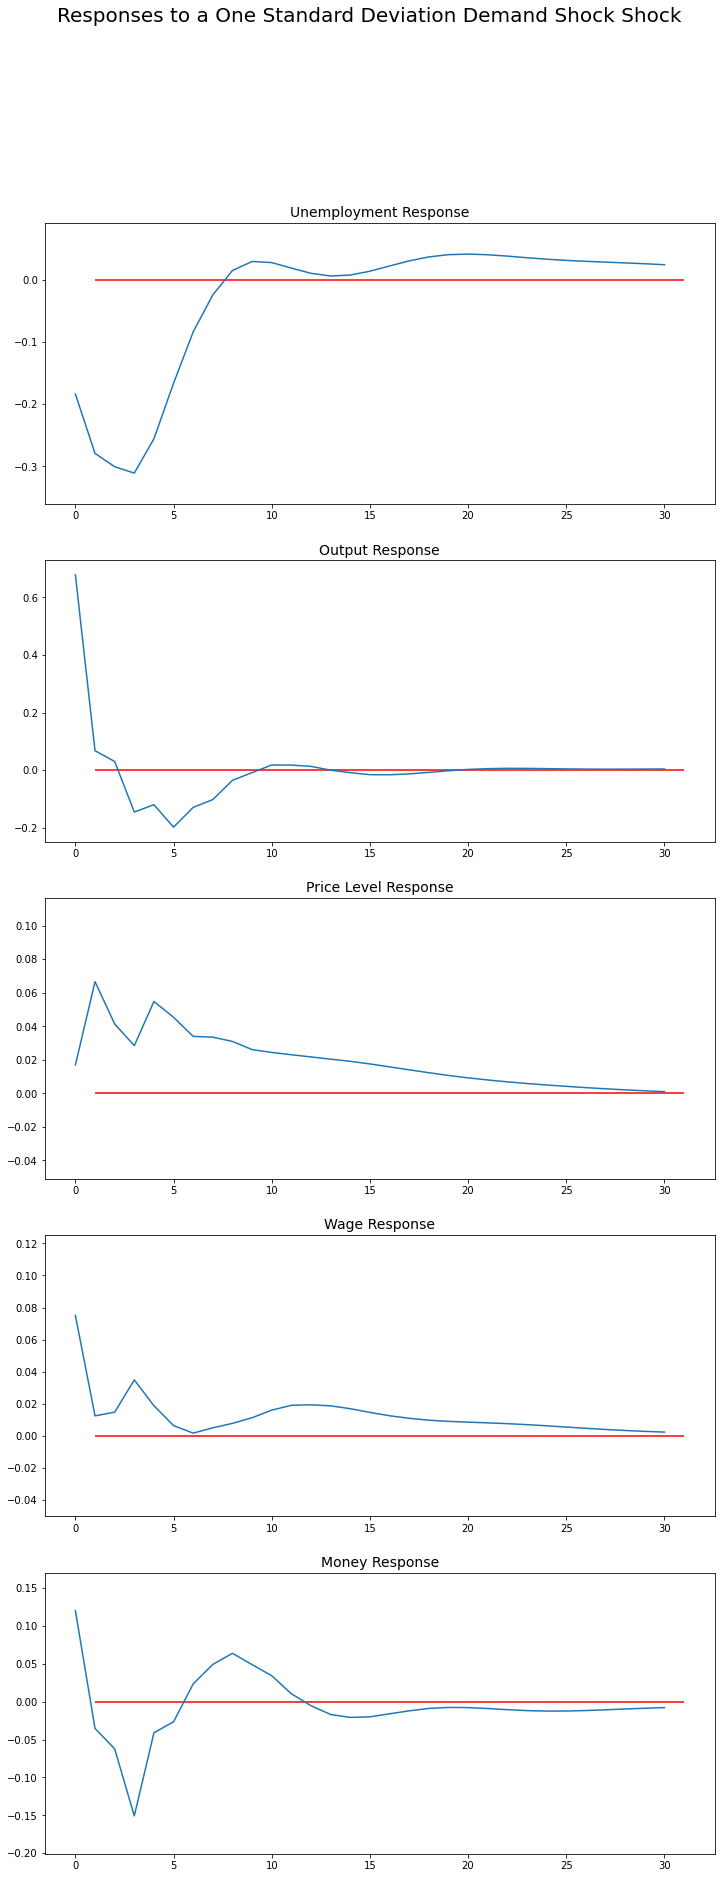

In [125]:
plot_IR(0)

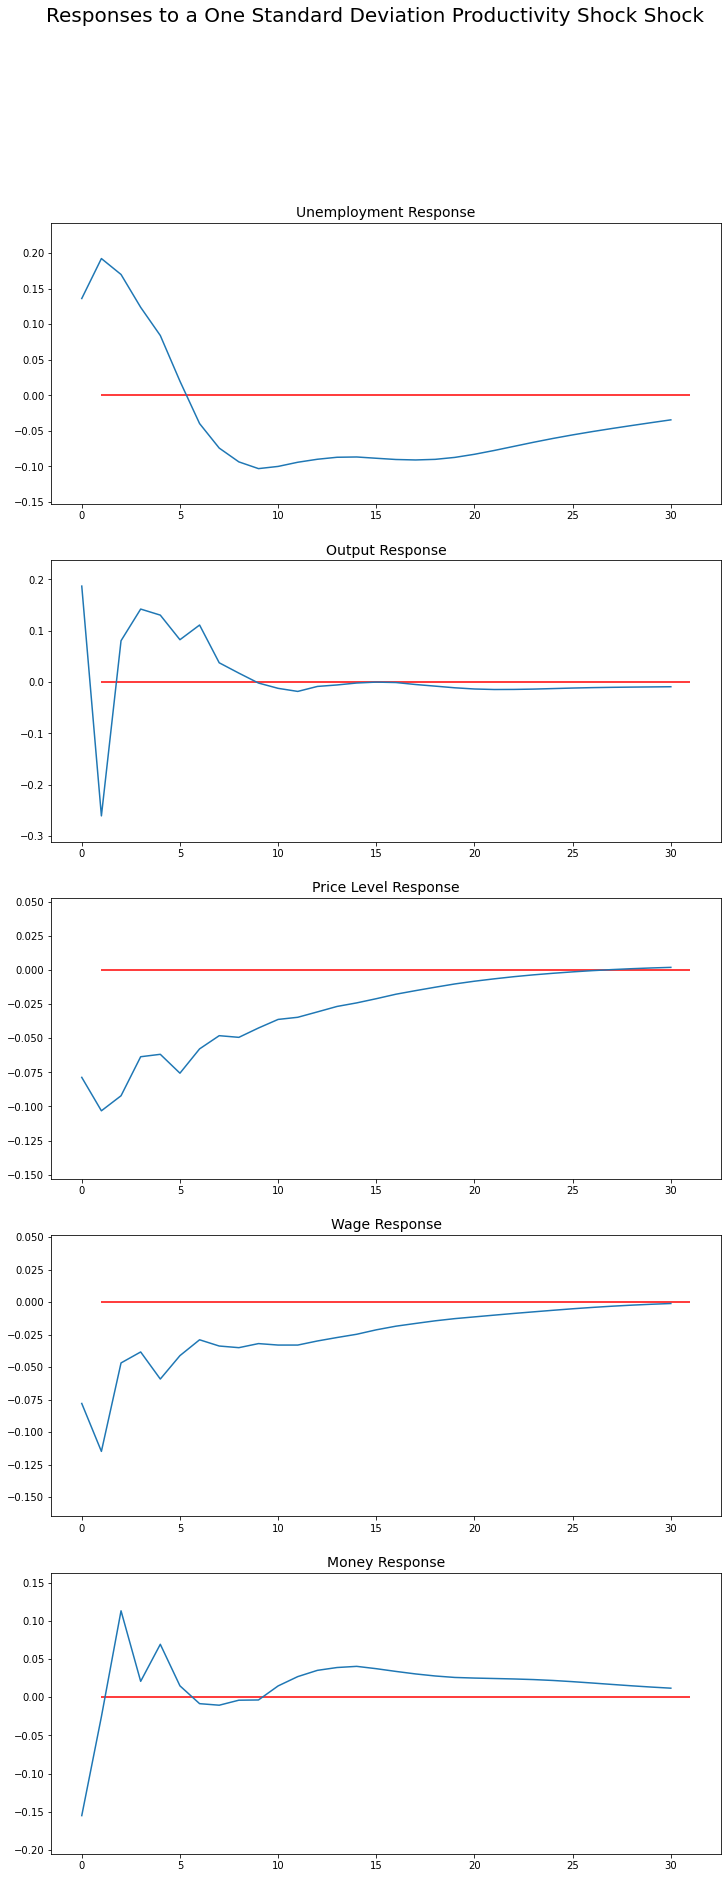

In [126]:
plot_IR(1)

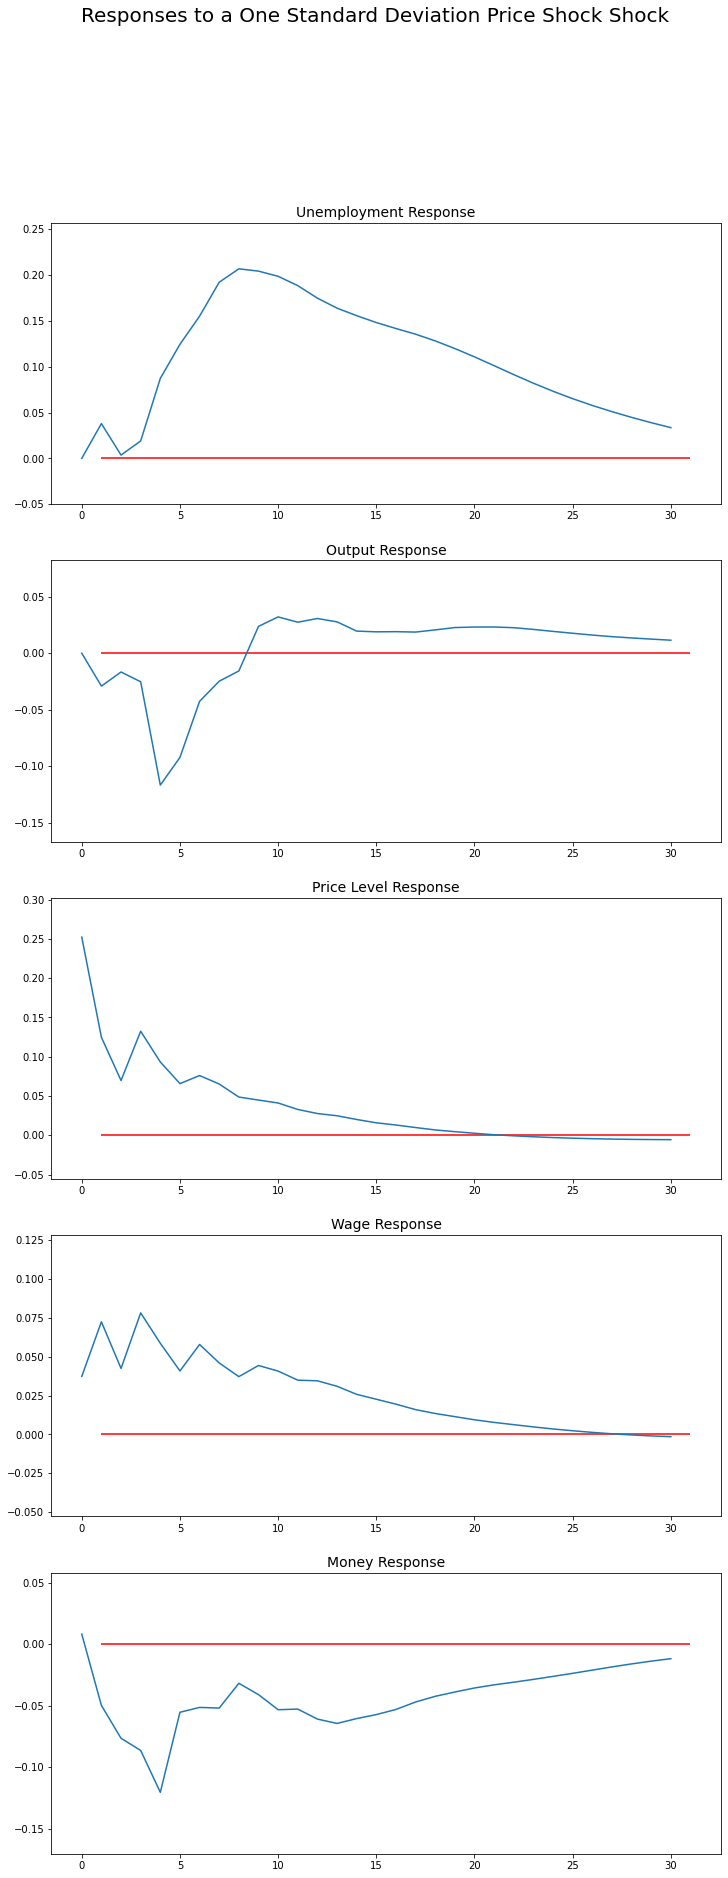

In [127]:
plot_IR(2)

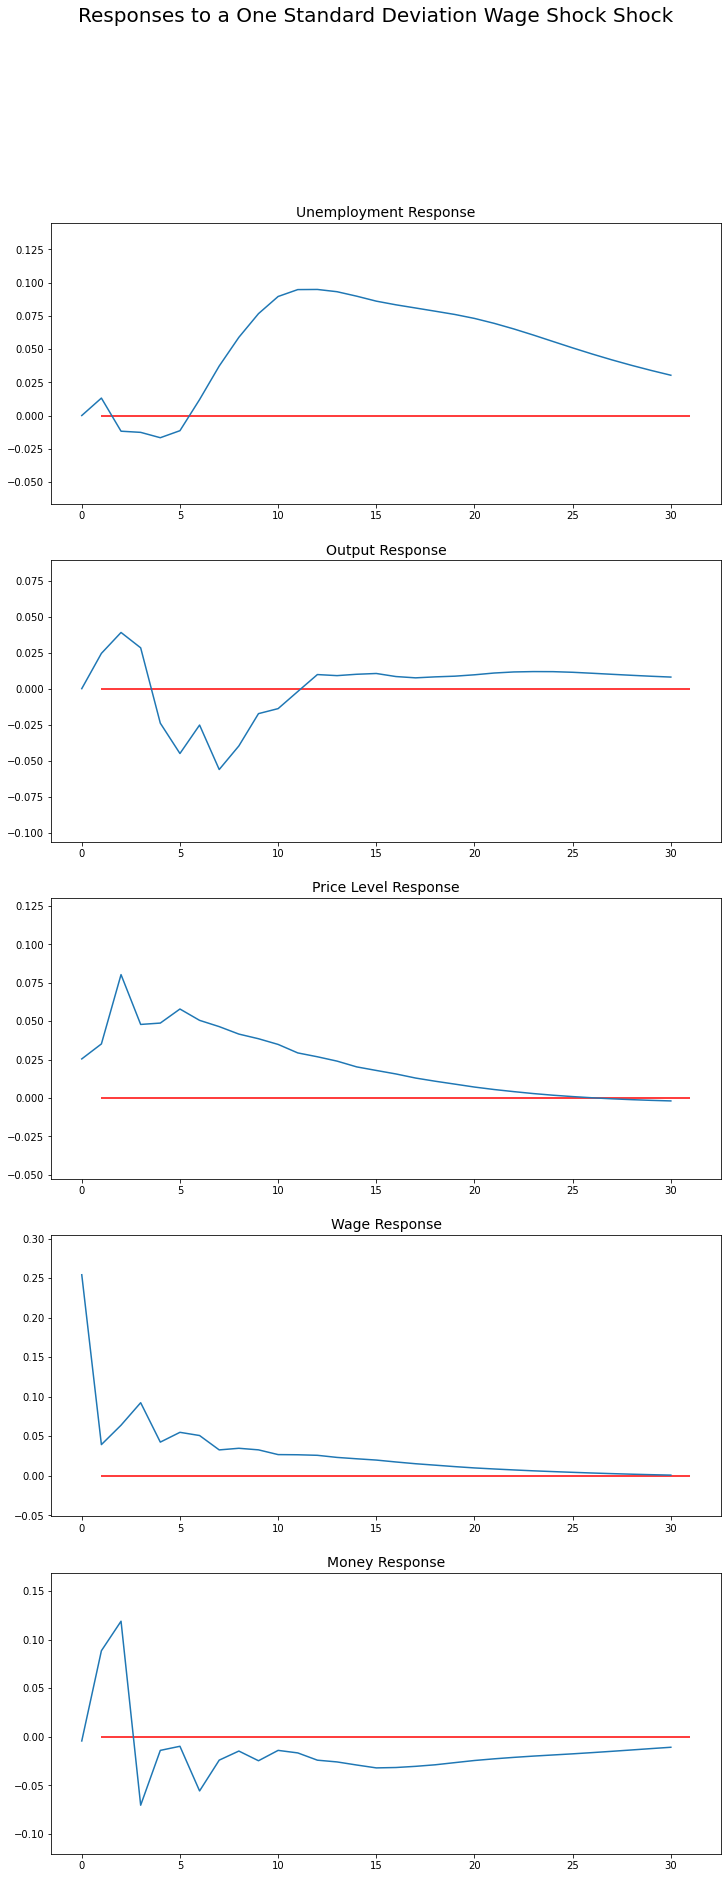

In [128]:
plot_IR(3)

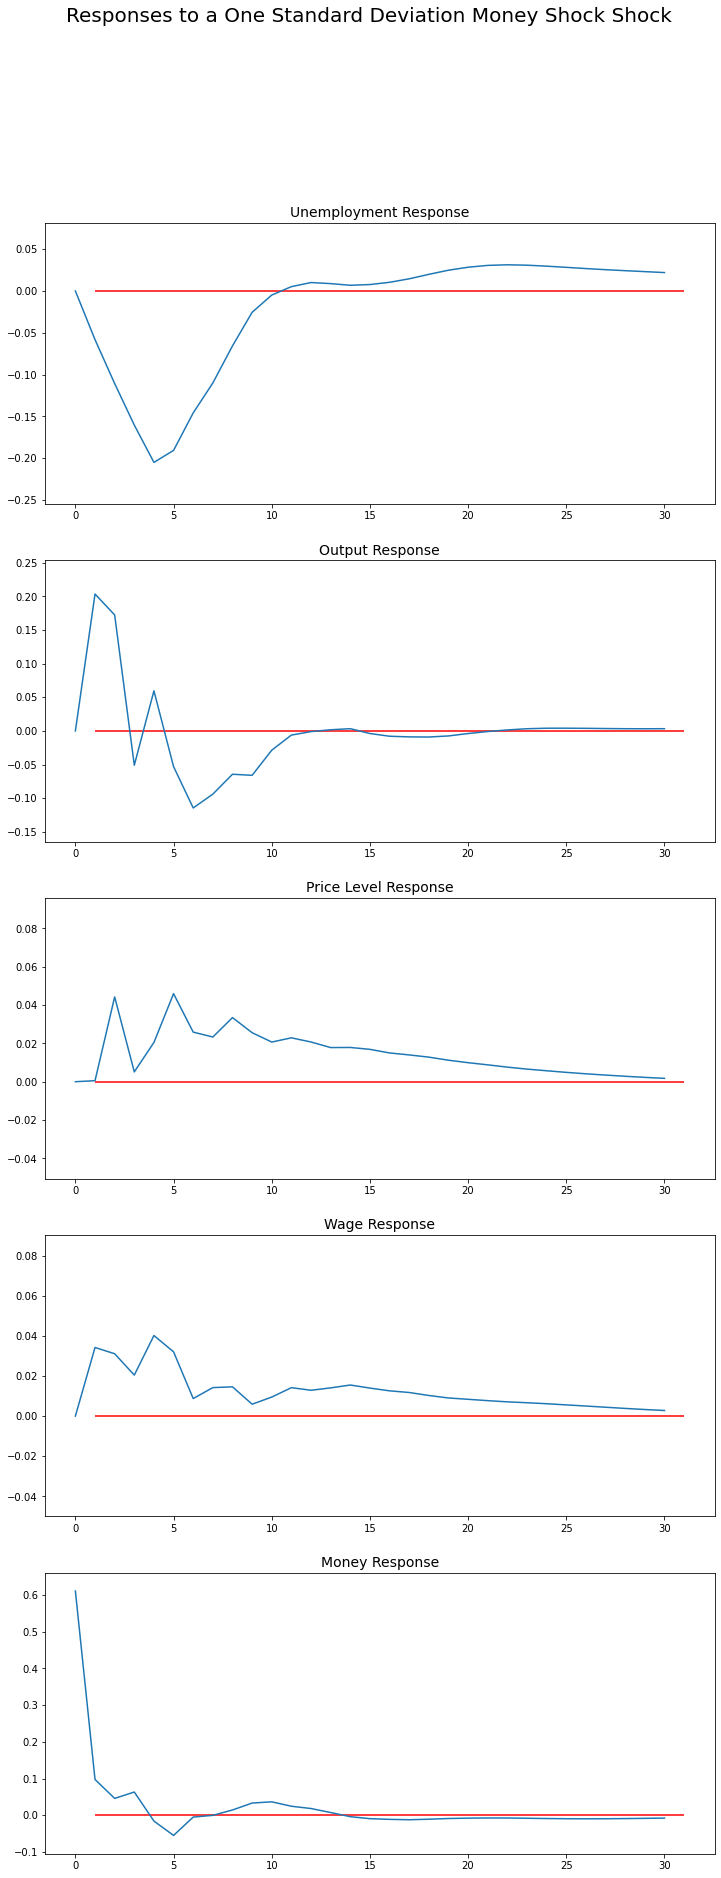

In [129]:
plot_IR(4)

모든 plot들이 대체로 논문의 plot과 일치하는 모습을 보였다.